In [7]:
from datasets import load_dataset
import matplotlib.pyplot as plt

# Tải bộ dữ liệu từ Hugging Face Hub
dataset = load_dataset("natix-network-org/roadwork")
train_ds = dataset["train"]
test_ds = dataset["test"]

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'id', 'width', 'height', 'license', 'flickr_url', 'coco_url', 'date_captured', 'gps', 'city_name', 'scene_description', 'video_info.frame_id', 'video_info.seq_id', 'video_info.vid_id', 'scene_level_tags.daytime', 'scene_level_tags.scene_environment', 'scene_level_tags.travel_alteration', 'scene_level_tags.weather', 'label'],
        num_rows: 6251
    })
    test: Dataset({
        features: ['image', 'id', 'width', 'height', 'license', 'flickr_url', 'coco_url', 'date_captured', 'gps', 'city_name', 'scene_description', 'video_info.frame_id', 'video_info.seq_id', 'video_info.vid_id', 'scene_level_tags.daytime', 'scene_level_tags.scene_environment', 'scene_level_tags.travel_alteration', 'scene_level_tags.weather', 'label'],
        num_rows: 2298
    })
})


Ảnh mẫu thuộc lớp 0:


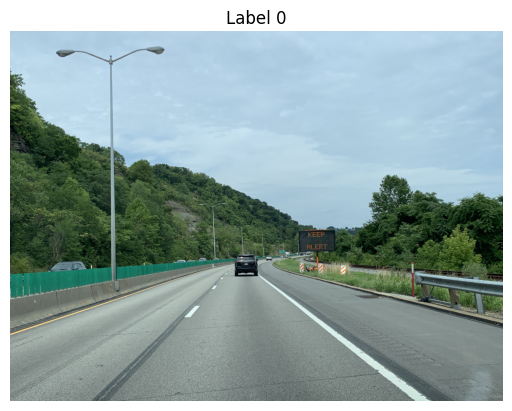

Ảnh mẫu thuộc lớp 1:


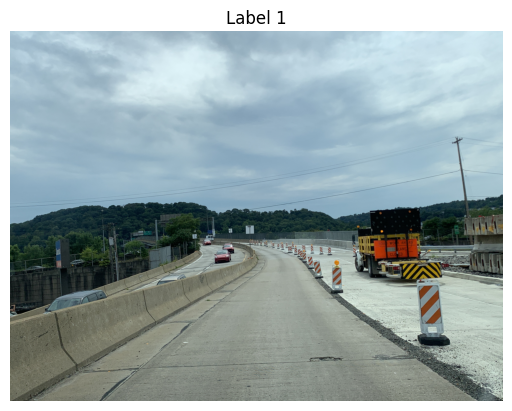

In [8]:
import matplotlib.pyplot as plt

# Duyệt và lấy mỗi lớp 1 ảnh đầu tiên
sample_label_0 = next(sample for sample in train_ds if sample["label"] == 0)
sample_label_1 = next(sample for sample in train_ds if sample["label"] == 1)

# Hiển thị ảnh có label = 0
print("Ảnh mẫu thuộc lớp 0:")
plt.imshow(sample_label_0["image"])
plt.axis("off")
plt.title("Label 0")
plt.show()

# Hiển thị ảnh có label = 1
print("Ảnh mẫu thuộc lớp 1:")
plt.imshow(sample_label_1["image"])
plt.axis("off")
plt.title("Label 1")
plt.show()


In [9]:
# đặt tên cho các lớp
label_names = {
    0: "No Roadwork",
    1: "Roadwork"
}


In [10]:
from transformers import AutoImageProcessor

# Tải processor cho ViT
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

# Hàm transform từng mẫu khi được truy xuất
def transform(example):
    image = example["image"].resize((224, 224))
    encoding = processor(image, return_tensors="pt")
    example["pixel_values"] = encoding["pixel_values"].squeeze()  # [3, 224, 224]
    return example

# Gán transform lazy cho tập train & test
train_ds.set_transform(transform)
test_ds.set_transform(transform)


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [11]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=2,
    id2label={0: "No Roadwork", 1: "Roadwork"},
    label2id={"No Roadwork": 0, "Roadwork": 1},
    ignore_mismatched_sizes=True  # ✅ THÊM DÒNG NÀY
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=2,  # Vì có 2 lớp
    id2label=label_names,  # Đặt lại tên lớp cho đẹp
    label2id={v: k for k, v in label_names.items()},
    ignore_mismatched_sizes=True  # Cho phép thay đổi output layer
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
# Upgrade transformers to the latest version to ensure compatibility
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",  # Đúng với transformers >= 4.0.0
    eval_steps=500,
    save_steps=500,
)


In [14]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }


In [16]:
from transformers import Trainer

# Update training_args to keep all columns (especially 'image')
training_args.remove_unused_columns = False

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()

AttributeError: 'list' object has no attribute 'resize'